## Module 1

In [3]:
import pandas as pd
import numpy as np
import regex as re

In [4]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

def normalize_text(text):
    only_alpha_num_regex = re.compile(r"[^A-Z0-9a-z\s]")
    stop_words = set(stopwords.words("english"))  
    stop_words.add('br')
    word_tokens = word_tokenize(text)
    
    word_tokens = [word for word in word_tokens if not word in stop_words]
    word_tokens = [word for word in word_tokens if not only_alpha_num_regex.match(word)]
    word_tokens = [word.lower() for word in word_tokens]
    text = TreebankWordDetokenizer().detokenize(word_tokens)
    return text

In [5]:
data_set = pd.read_csv("movie_reviews.csv")
data_set_column_names = list(data_set.columns)
data_set_normalized = pd.DataFrame()
for column_name in data_set_column_names:
    data_set_normalized[column_name] = data_set.apply(lambda row: normalize_text(row[column_name]), axis=1)

## Module 2

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer 
tfidf_vectorizer = TfidfVectorizer(use_idf=True) 
reviews_vectorized_text = tfidf_vectorizer.fit_transform(data_set_normalized["review"])

In [8]:
def display_data(vectorizer, tfidf_res):
    data_frames = []
    for vector in tfidf_res:
        df = pd.DataFrame(vector.T.todense(), index=vectorizer.get_feature_names(), columns=["tfidf score"])
        data_frames.append(df)
    return pd.concat(data_frames)

In [6]:
df_idf = display_data(tfidf_vectorizer, reviews_vectorized_text[:100])
df_idf.sort_values(by=["tfidf score"],ascending=False)

,tfidf score
jimmy,0.687814
mario,0.684188
dutcher,0.622986
musical,0.614340
wait,0.601913
...,...
froides,0.000000
froing,0.000000
frokost,0.000000
frolic,0.000000


In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
reviews_standardized = sc.fit_transform(reviews_vectorized_text)

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [11]:
from sklearn.model_selection import train_test_split
sentiments = [1 if row[1] == "positive" else 0 for row in  data_set_normalized[["sentiment"]].itertuples()]

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(reviews_standardized, sentiments, test_size=0.2) # 80% training - 20% testing

In [13]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(x_train, y_train)

MultinomialNB()

In [14]:
y_pred = naive_bayes_classifier.predict(x_test)

score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, y_pred)

accuracy:   0.753


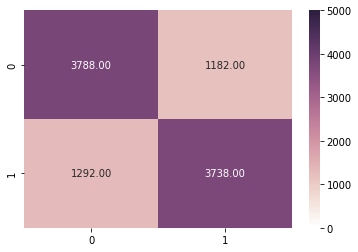

In [16]:
import seaborn as sn
cmap = sn.cubehelix_palette(light=1, as_cmap=True)
res = sn.heatmap(cm, annot=True, vmin=0.0, vmax=5000.0, fmt='.2f', cmap=cmap)

## Module 3

In [17]:
features = ["title", "sentiment", "genre",]
sent_genre_df = pd.DataFrame()
for feature in features:
    sent_genre_df[feature] = data_set_normalized[feature].fillna("")

In [18]:
sent_genre_df["sent_genre"] = sent_genre_df["sentiment"] + " " + sent_genre_df["genre"]

In [19]:
sent_genre_df[:10]

,title,sentiment,genre,sent_genre
0,miss jerry,positive,romance,positive romance
1,the story kelly gang,positive,biography crime drama,positive biography crime drama
2,den sorte drøm,positive,drama,positive drama
3,cleopatra,negative,drama history,negative drama history
4,l'inferno,positive,adventure drama fantasy,positive adventure drama fantasy
5,from manger cross jesus nazareth,positive,biography drama,positive biography drama
6,madame dubarry,positive,biography drama romance,positive biography drama romance
7,quo vadis,negative,drama history,negative drama history
8,independenta romaniei,negative,history war,negative history war
9,richard iii,positive,drama,positive drama


In [20]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True) 
sent_genre_vectorized_text = tfidf_vectorizer.fit_transform(sent_genre_df["sent_genre"])

In [21]:
sc = StandardScaler(with_mean=False)
sent_genre_standardized = sc.fit_transform(sent_genre_vectorized_text)

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(sent_genre_standardized)

In [23]:
def get_index_from_title(title):
    index = sent_genre_df[sent_genre_df.title == title].index
    return index.values[0] if len(index) > 0 else -1

def get_title_from_index(index):
    return sent_genre_df[sent_genre_df.index == index]["title"].values[0]

def get_10_similar_movie_titles(similar_movie_indices):
    i = 0
    for similar_movie_index in similar_movie_indices:
        print(get_title_from_index(similar_movie_index[0]).title())
        i = i + 1
        if(i == 10):
            return

In [21]:
print("Enter Movie Title")
user_input = input()
movie_index = get_index_from_title(user_input.lower())
if(movie_index < 0):
    print("Sorry, movie does not exist in our database.")
else:
    similar_movie_indices = list(enumerate(cosine_sim[movie_index]))
    sorted_similar_movie_indices = sorted(similar_movie_indices, key=lambda x:x[1], reverse=True)
    get_10_similar_movie_titles(sorted_similar_movie_indices[1:])

Enter Movie Title
miss jerry
Das Wandernde Bild
The Bride Play
I Met My Love Again
Katariina Ja Munkkiniemen Kreivi
Blaze Starr Goes Nudist
Tri Topolya Na Plyushchikhe
Tredowata
Kogda Ya Stanu Velikanom
Sadma
En Film Om Kärlek


In [ ]:
print("Enter Movie Title")
user_input = input()
movie_index = get_index_from_title(user_input.lower())
if(movie_index < 0):
    print("Sorry, movie does not exist in our database.")
else:
    similar_movie_indices = list(enumerate(cosine_sim[movie_index]))
    sorted_similar_movie_indices = sorted(similar_movie_indices, key=lambda x:x[1], reverse=True)
    get_10_similar_movie_titles(sorted_similar_movie_indices[1:])

Enter Movie Title
